## Loading Dataset

In [1]:
import pickle
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model, metrics, svm, neighbors, gaussian_process, ensemble, neural_network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Using TensorFlow backend.


In [2]:
df = pickle.load(open("datafiles/after-EDA.ft", "rb"))
df.head()

,totPurchaseAmt,latitude,longitude,bathrooms,photoCount,bedrooms,livingArea,yearBuilt,averageSchoolRating,zip,zestimate,sentiment
1,198000.0,45.237189,-93.409535,2.0,0,4.0,1716.0,1996,5.333333,55303,285985.0,0.4939
3,415000.0,45.278217,-93.407533,2.0,30,3.0,3108.0,1985,6.333333,55303,431995.0,0.2617
4,329900.0,45.143781,-93.021604,3.0,0,4.0,1814.0,2001,6.500000,55038,318162.0,0.2732
5,262000.0,45.164166,-93.297836,2.0,36,3.0,2158.0,1985,4.666667,55043,272169.0,0.9136
6,280000.0,45.283700,-93.332023,2.0,22,3.0,1993.0,1976,7.333333,55304,290365.0,0.9428


In [3]:
len(df)

28078

In [4]:
grouped = df.groupby('zip')
df = grouped.filter(lambda x: x['zip'].count() > 100)  # Use ZipCode where there are atleast 100 listings

## Converting Categorical Variables 

In [5]:
df = pd.get_dummies(data=df, columns=["zip"])
df.head()

,totPurchaseAmt,latitude,longitude,bathrooms,photoCount,bedrooms,livingArea,yearBuilt,averageSchoolRating,zestimate,...,zip_55431,zip_55432,zip_55433,zip_55434,zip_55437,zip_55443,zip_55446,zip_55447,zip_55448,zip_55449
1,198000.0,45.237189,-93.409535,2.0,0,4.0,1716.0,1996,5.333333,285985.0,...,0,0,0,0,0,0,0,0,0,0
3,415000.0,45.278217,-93.407533,2.0,30,3.0,3108.0,1985,6.333333,431995.0,...,0,0,0,0,0,0,0,0,0,0
4,329900.0,45.143781,-93.021604,3.0,0,4.0,1814.0,2001,6.500000,318162.0,...,0,0,0,0,0,0,0,0,0,0
6,280000.0,45.283700,-93.332023,2.0,22,3.0,1993.0,1976,7.333333,290365.0,...,0,0,0,0,0,0,0,0,0,0
7,237000.0,45.105931,-93.261656,2.0,53,3.0,2058.0,1959,3.666667,246844.0,...,0,1,0,0,0,0,0,0,0,0


## Train Test Split 

In [6]:
X = df.drop(columns=["totPurchaseAmt", "latitude", "longitude", "zestimate"])  # Dropping target variable, latitude and longitude
y = df["totPurchaseAmt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  # Train Test split of 70:30

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

## Models

In [8]:
# Trying to Build Neural Network Model

def create_model(optimizer = 'adam'):
  cnn_model = Sequential()

  n_cols = X_train.shape[1]
  cnn_model.add(Dense(16, activation='relu', input_shape=(n_cols,)))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(256, activation='relu'))
  cnn_model.add(Dense(256, activation='relu'))
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dense(16, activation='relu'))
  cnn_model.add(Dense(1))

  cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=["mae"])

  return cnn_model

In [9]:
models = {
    "Neural Network" : create_model(),
    "Linear Regression" : linear_model.LinearRegression(n_jobs=-1), 
    "Support Vector Machine" : svm.SVR(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Ridge Regression" : linear_model.Ridge(alpha=.5),
    "Least Angle Regression" : linear_model.LassoLars(alpha=.1),
    "Bayesian Ridge Regression" : linear_model.BayesianRidge(),
    "SGD Regressor" : linear_model.SGDRegressor(),
    "Nearest Neighbors Regression" : neighbors.KNeighborsRegressor(n_jobs=-1),
    "Gaussian Process" : gaussian_process.GaussianProcessRegressor(),
    "Random Forest" : ensemble.RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting Regressor' : ensemble.GradientBoostingRegressor()
}

results = []

for model_name in models:
    model = models[model_name]

    if model_name == "Neural Network":
        model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print ("=== " + model_name + " ===")
    results.append([model_name, round(metrics.mean_absolute_error(y_test, y_pred), 3),
                    round(metrics.mean_squared_error(y_test, y_pred), 3), 
                    round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)])

=== Neural Network ===
=== Linear Regression ===
=== Support Vector Machine ===
=== Decision Tree ===
=== Ridge Regression ===
=== Least Angle Regression ===
=== Bayesian Ridge Regression ===
=== SGD Regressor ===
=== Nearest Neighbors Regression ===
=== Gaussian Process ===
=== Random Forest ===
=== Gradient Boosting Regressor ===


In [10]:
pd.set_option('display.float_format', '{:.2f}'.format)

dfResults = pd.DataFrame(results, columns =['Model Name', 'MAE', 'MSE', 'RMSE']) 
dfResults.sort_values(by=["MAE"])

,Model Name,MAE,MSE,RMSE
0,Neural Network,55301.31,11222014757.36,105934.01
10,Random Forest,56980.61,11210208167.23,105878.27
11,Gradient Boosting Regressor,58160.05,11584432519.93,107631.00
6,Bayesian Ridge Regression,62351.11,11919372050.76,109175.88
5,Least Angle Regression,62471.32,11925014473.51,109201.71
4,Ridge Regression,62483.00,11925502387.65,109203.95
1,Linear Regression,62982.16,11966156905.65,109389.93
8,Nearest Neighbors Regression,63167.14,12689241036.52,112646.53
7,SGD Regressor,66819.95,12753993922.07,112933.58
3,Decision Tree,78109.52,21371952657.05,146191.49


## Feature Importance

In [11]:
model = ensemble.RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

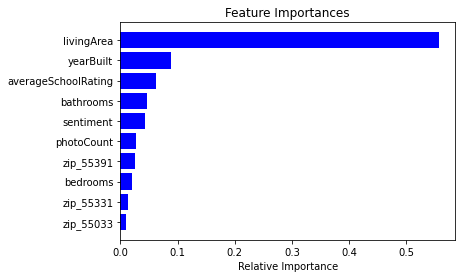

In [12]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Grid Search for Best HyperParameter - Random Forest

In [41]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = ensemble.RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_split=5,
                      n_estimators=400)

In [43]:
y_pred = rf_random.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 53839.61040534441
Mean Squared Error: 11723129631.063478
Root Mean Squared Error: 108273.40223278974




The purpose of this project is to predict house value using a variety of machine learning methods. Both homebuyers and sellers need a reliable metric in order to either determine if a house price is a fair deal. In order for this to happen, natural language, and numerical features will be combined into a machine learning pipeline. 

We use Mean Absolute Error (MAE) as our evaluator of success. Our system was able to achieve an MAE of \\$53,839. For reference, Zillow's Z-Estimate feature has an MAE of \\$44,800 on the dataset we created. That is a difference of $9,039 (about 16%) between our method and Zillow's

### Future Steps

* Could build more optimized Neural Networks by trying out different Neuron Layouts and Activation Layers

* Could scrape more data for the model to learn from

* Use images of the house as an attribute to boost the accuracy of the model

* Use Latitude and Longitude to understand the position of the house (Corner House, in a Cul-de-sac, etc.)

* Understand Seasonality of the house prices in a given region